In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

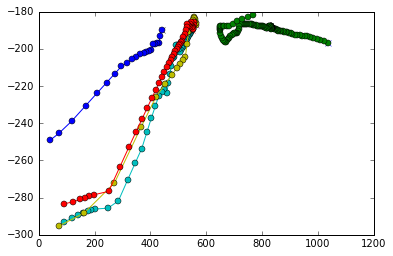

In [59]:
def displayTracks(tracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        track = np.array(tracks.items()[i][1])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o")
displayTracks(tracks, 5)

In [4]:
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [5]:
np.random.seed(7)

In [6]:
def buildDataset(tracks):
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < len(track)-1:
                dataset.append((tuple(pos + track[i+1])))
    return dataset
                
dataset = buildDataset(tracks) 
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(17903, 8818)


In [9]:
xtrain = np.matrix(train[:,0:2])
ytrain = np.matrix(train[:,2:])
xtest = np.matrix(test[:,0:2])
ytest = np.matrix(test[:,2:])

In [10]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 1, xtest.shape[1]))

In [11]:
xsample = xtrain[0, :]
ysample = ytrain[0,:]
print xsample
print ysample

[[ 0.62446123  0.10217015]]
[[ 0.62740964  0.09628095]]


In [12]:
xsample = np.array(xsample).reshape((1,1,2))


In [13]:
model = Sequential()
model.add(LSTM(4, input_dim=2))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xtrain, ytrain, nb_epoch=10, batch_size=1, verbose=2)

Epoch 1/10
29s - loss: 0.0067
Epoch 2/10
25s - loss: 2.0092e-04
Epoch 3/10
24s - loss: 1.8829e-04
Epoch 4/10
26s - loss: 1.8362e-04
Epoch 5/10
24s - loss: 1.8130e-04
Epoch 6/10
22s - loss: 1.7969e-04
Epoch 7/10
29s - loss: 1.8012e-04
Epoch 8/10
25s - loss: 1.8043e-04
Epoch 9/10
25s - loss: 1.8086e-04
Epoch 10/10
23s - loss: 1.7812e-04


In [14]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 0.0132193 RMSE
Test Score: 0.0129152 RMSE


In [43]:
# Note this will predict the new point one frame ahead and build a track by 
# using measurements from the previous measurement.
# The first prediction is exactly the first measurement
# The last prediction is emitted because we know that the object is gone
# but currently the model has no method for predicting the death of an object
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i == 0:
                t.append(pos)
            else:
                # scale and resize
                p = track[1][i-1]
                p = scaler.transform(np.array(p+p).reshape(1,-1))[0][0:2].reshape(1,1,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]).reshape(1,-1))[0][0:2]
                t.append(pred)
    return predTracks

In [44]:
predictedTracks = rebuildTracks(tracks,model)

In [60]:
def displayPredictedTracks(tracks,predictedTracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        key = tracks.items()[i][0]
        track = np.array(tracks.items()[i][1])
        t2 = np.array(predictedTracks[key])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o", color='b')
        plt.plot(t2[:,0], -t2[:,1], marker="s", color='r')


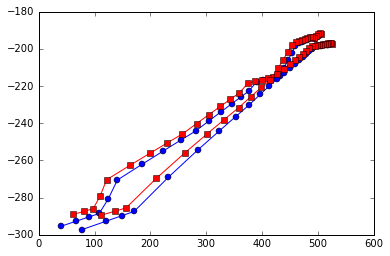

In [70]:
# Note that this includes training data so it may be overfit for some
displayPredictedTracks(tracks,predictedTracks, 2)